# `response` Subpackage Tutorial

This notebook will demo the capabilities of the `response` subpackage in `aiapy`, specifically the `Channel` object which can be used to compute the wavelength response function (and eventually the temperature response functions).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.time
import sunpy.map
import sunpy.time
import drms

import aiapy.response

%matplotlib inline

## The `Channel` Object

The `response` subpackage is organized around the `Channel` object. We can instantiate a `Channel` object simply by passing in a wavelength (with units!),

In [2]:
chan = aiapy.response.Channel(335*u.angstrom,)

When this object is created it looks for the `aia_V{}_all_fullinst.genx` in `$HOME/sunpy/data`. If it is not there, it downloads the file. Thus, the first time you create the object, it may take a bit longer because the file is being downloaded.

This object represents the 335 Å channel and holds various bits of metadata associated with the channel,

In [3]:
chan.channel

<Quantity 335. Angstrom>

In [4]:
chan.name

'335'

## Effective area

To calculate the effective area,

In [5]:
chan.effective_area

<Quantity [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1471075e-10,
           1.1393573e-10, 1.1316663e-10] cm2>

Note that it has units of cm$^2$. We can also plot it as a function of wavelength,

(315.0, 355.0)

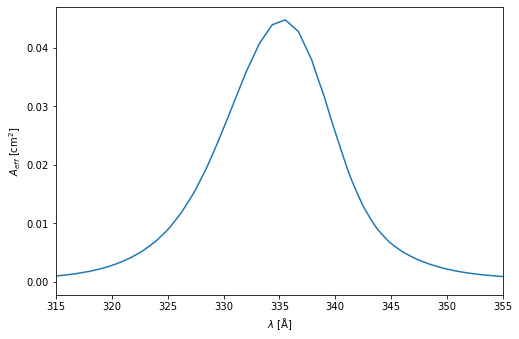

In [6]:
plt.figure(figsize=(8,5.3))
plt.plot(chan.wavelength,chan.effective_area)
plt.xlabel(r'$\lambda$ [Å]')
plt.ylabel(r'$A_{eff}$ [cm$^2$]')
plt.xlim((chan.channel + [-20,20]*u.angstrom).value)

From [Boerner et al. (2012)](http://adsabs.harvard.edu/abs/2012SoPh..275...41B), the effective area is given by,

$$
A_{eff}(\lambda) = A_{geo}R_P(\lambda)R_S(\lambda)T_E(\lambda)T_F(\lambda)D(\lambda)Q(\lambda),
$$

where,

- $A_{geo}$ geometrical collecting area
- $R_P,R_S$ reflectances of primary and secondary mirrors, respectively
- $T_E, T_F$ transmission efficiency of the entrance and focal-plane filters, respectively
- $D$ contaminant transmittance of optics
- $Q$ quantum efficiency of the CCD

We can also access each of these individual components as attributes,

In [7]:
chan.geometrical_collecting_area

<Quantity 83. cm2>

Text(0.5, 0, '$\\lambda$ [Å]')

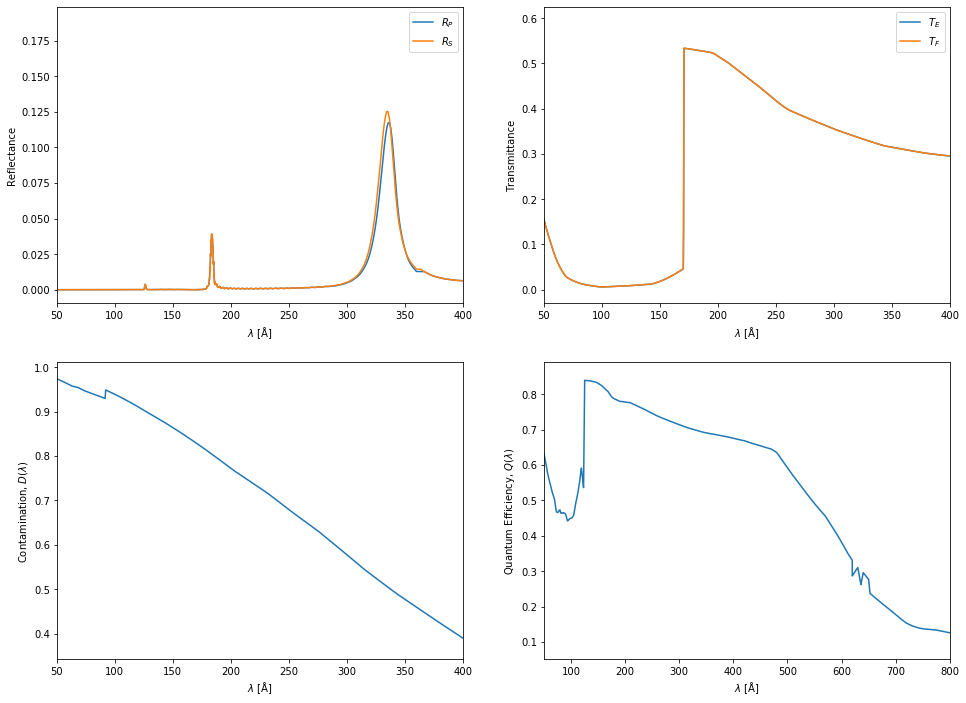

In [8]:
fig,axes = plt.subplots(2,2,figsize=(16,12),sharex=False)
# Reflectance
axes[0,0].plot(chan.wavelength,chan.primary_reflectance,label=r'$R_P$')
axes[0,0].plot(chan.wavelength,chan.secondary_reflectance,label=r'$R_S$')
axes[0,0].legend()
axes[0,0].set_ylabel(r'Reflectance')
axes[0,0].set_xlim(50,400)
axes[0,0].set_xlabel(r'$\lambda$ [Å]')
# Transmittance
axes[0,1].plot(chan.wavelength,chan.entrance_filter_efficiency,label=r'$T_E$')
axes[0,1].plot(chan.wavelength,chan.focal_plane_filter_efficiency,label=r'$T_F$')
axes[0,1].legend()
axes[0,1].set_ylabel(r'Transmittance')
axes[0,1].set_xlim(50,400)
axes[0,1].set_xlabel(r'$\lambda$ [Å]')
# Contamination
axes[1,0].plot(chan.wavelength, chan.contamination)
axes[1,0].set_ylabel(r'Contamination, $D(\lambda)$')
axes[1,0].set_xlim(50,400)
axes[1,0].set_xlabel(r'$\lambda$ [Å]')
# Efficiency
axes[1,1].plot(chan.wavelength, chan.quantum_efficiency)
axes[1,1].set_ylabel(r'Quantum Efficiency, $Q(\lambda)$')
axes[1,1].set_xlim(50,800)
axes[1,1].set_xlabel(r'$\lambda$ [Å]')

For more information on these quantities, see Section 2.1 of [Boerner et al. (2012)](http://adsabs.harvard.edu/abs/2012SoPh..275...41B).

## Wavelength Response

We define the wavelength response function, $R(\lambda)$ as,

$$
R(\lambda) = A_{eff}(\lambda)G(\lambda)
$$

where,

$$
G(\lambda) = \frac{hc}{\lambda}\frac{g}{\varepsilon}
$$

is the gain of the CCD camera system for the 131 Å channel, $\varepsilon$ is an electrons per eV conversion factor, and $g$ is camera gain.

To calculate the wavelength response,

In [9]:
r = chan.wavelength_response()

Note that $R(\lambda)$ has units of cm$^2$ DN photon$^{-1}$.

In [10]:
r

<Quantity [1.6854788e-08, 1.6595683e-08, 1.6341122e-08, ..., 2.5859875e-11,
           2.5686821e-11, 2.5515087e-11] cm2 ct / ph>

To plot the response function,

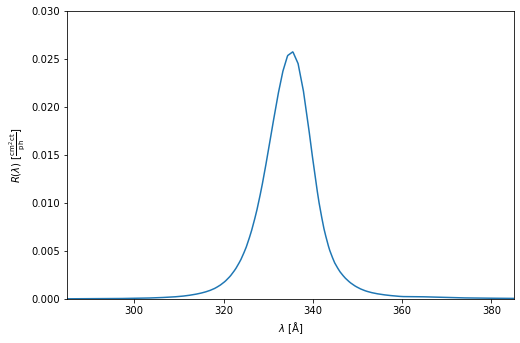

In [11]:
plt.figure(figsize=(8,5.3))
plt.plot(chan.wavelength,r)
plt.xlim(axes[0,0].set_xlim((chan.channel + [-50,50]*u.angstrom).value))
plt.ylim(0,0.03)
plt.xlabel(r'$\lambda$ [Å]')
plt.ylabel(f'$R(\lambda)$ [{r.unit.to_string("latex")}]');

By default, a correction is applied to account for crosstalk between channels on the same telescope (where appropriate). To disable this correction,

In [12]:
r_no_crosstalk = chan.wavelength_response(include_crosstalk=False)

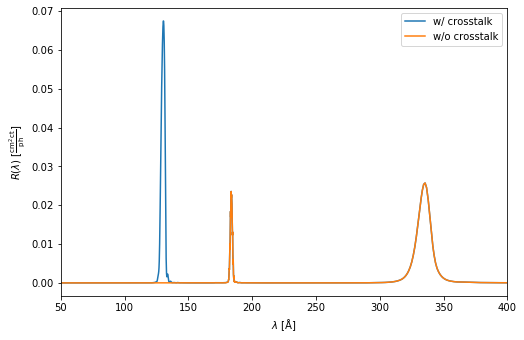

In [13]:
plt.figure(figsize=(8,5.3))
plt.plot(chan.wavelength,r,label='w/ crosstalk')
plt.plot(chan.wavelength,r_no_crosstalk, label='w/o crosstalk')
plt.xlim(50,400)
plt.xlabel(r'$\lambda$ [Å]')
plt.ylabel(f'$R(\lambda)$ [{r.unit.to_string("latex")}]');
plt.legend()

Becuase the 335 and 131 Å channels share a telescope, there is significant crosstalk between these two channels.

## Time-dependent Corrections

There are a couple of time-dependent corrections that can be applied to the wavelength response functions. The first is an explicit time-dependent correction to account for the degradation. This correction consists of two multiplicative factors on the uncorrected wavelength response: one that corrects to the current epoch and one that interpolates within that epoch,

$$
\frac{A_{eff}(t_{e})}{A_{eff}(t_0)}(1 + p_1\delta t + p_2\delta t^2 + p_3\delta t^3)
$$
        
where $A_{eff}(t_e)$ is the effective area calculated at the current calibration epoch, $A_{eff}(t_0)$ is the effective area at the first calibration epoch (i.e. at launch), $p_1,p_2,p_3$ are the interpolation coefficients for the current epoch, and $`\delta t$ is the difference between the start time of the epoch and observation time.

To include this correction, we simply specify an observation time in the wavelength response method. We will calculate it using the correction to the most recent epoch.

In [14]:
now = astropy.time.Time.now()

In [15]:
r_now = chan.wavelength_response(obstime=now)

Comparing the uncorrected response and the response including degradation up to right now, we find that the 335 Å channel is significantly degraded.

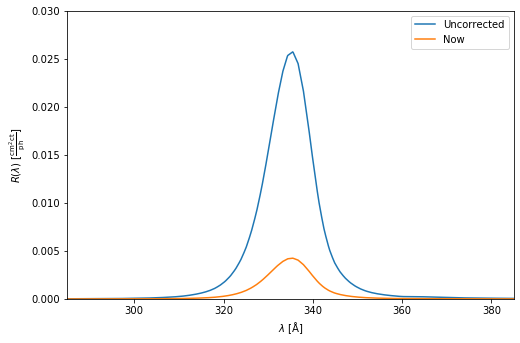

In [16]:
plt.figure(figsize=(8,5.3))
plt.plot(chan.wavelength,r,label='Uncorrected')
plt.plot(chan.wavelength,r_now, label='Now')
plt.xlim(axes[0,0].set_xlim((chan.channel + [-50,50]*u.angstrom).value))
plt.ylim(0,0.03)
plt.xlabel(r'$\lambda$ [Å]')
plt.ylabel(f'$R(\lambda)$ [{r.unit.to_string("latex")}]');
plt.legend()

If we have a particular observation loaded as a `sunpy.map.Map` object and we want to calculate the response function at the time of that observation, we can easily extract the observation time from that map and pass it to our response function method,

In [17]:
m = sunpy.map.Map('/Users/willbarnes/sunpy/data/aia_lev1_335a_2010_12_01t19_00_03_62z_image_lev1.fits')#q['image'][0])

In [18]:
r_map = chan.wavelength_response(obstime=m.date)

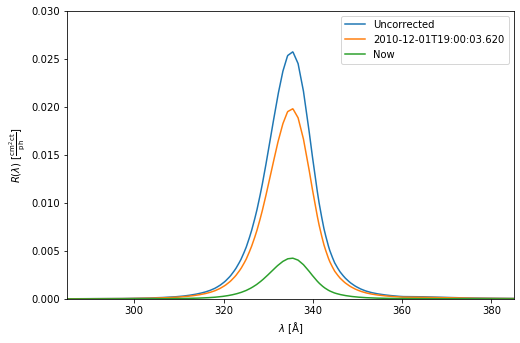

In [19]:
plt.figure(figsize=(8,5.3))
plt.plot(chan.wavelength,r,label='Uncorrected')
plt.plot(chan.wavelength,r_map,label=f'{m.date}')
plt.plot(chan.wavelength,r_now, label='Now')
plt.xlim(axes[0,0].set_xlim((chan.channel + [-50,50]*u.angstrom).value))
plt.ylim(0,0.03)
plt.xlabel(r'$\lambda$ [Å]')
plt.ylabel(f'$R(\lambda)$ [{r.unit.to_string("latex")}]');
plt.legend()

## Efficiently Calculating Many Response Functions

It is easy to mimic the interface of `aia_get_response.pro` by simply wrapping the `Channel` object in a function and then iterating over all of the relevant channels.

However, there's some additional overhead incurred both by reading the instrument data file and querying JSOC for the correction parameters. When retrieving multiple response functions, this overhead can be easily avoided by simply pre-fetching or reading the tables and then passing them into their respective functions. An example is shown below.

In [20]:
def aia_get_response(**kwargs):
    channels = [94,131,171,193,211,304,335] * u.angstrom
    # Get correction table
    correction_table = aiapy.response.util.get_correction_table()
    
    response_funcs = {}
    instrument_data = None
    for c in channels:
        chan = aiapy.response.Channel(c, instrument_file=instrument_data)
        # Only read instrument data once, save for later calculations
        if instrument_data is None:
            instrument_data = chan._instrument_data
        r = chan.wavelength_response(correction_table=correction_table, **kwargs)
        response_funcs[c] = {
            'wavelength': chan.wavelength,
            'response': r,
        }
        
    return response_funcs

In [21]:
response_all = aia_get_response()

In [22]:
response_all_now = aia_get_response(obstime=now)

Finally, let's plot all of the wavelength responses as a function of wavelength.

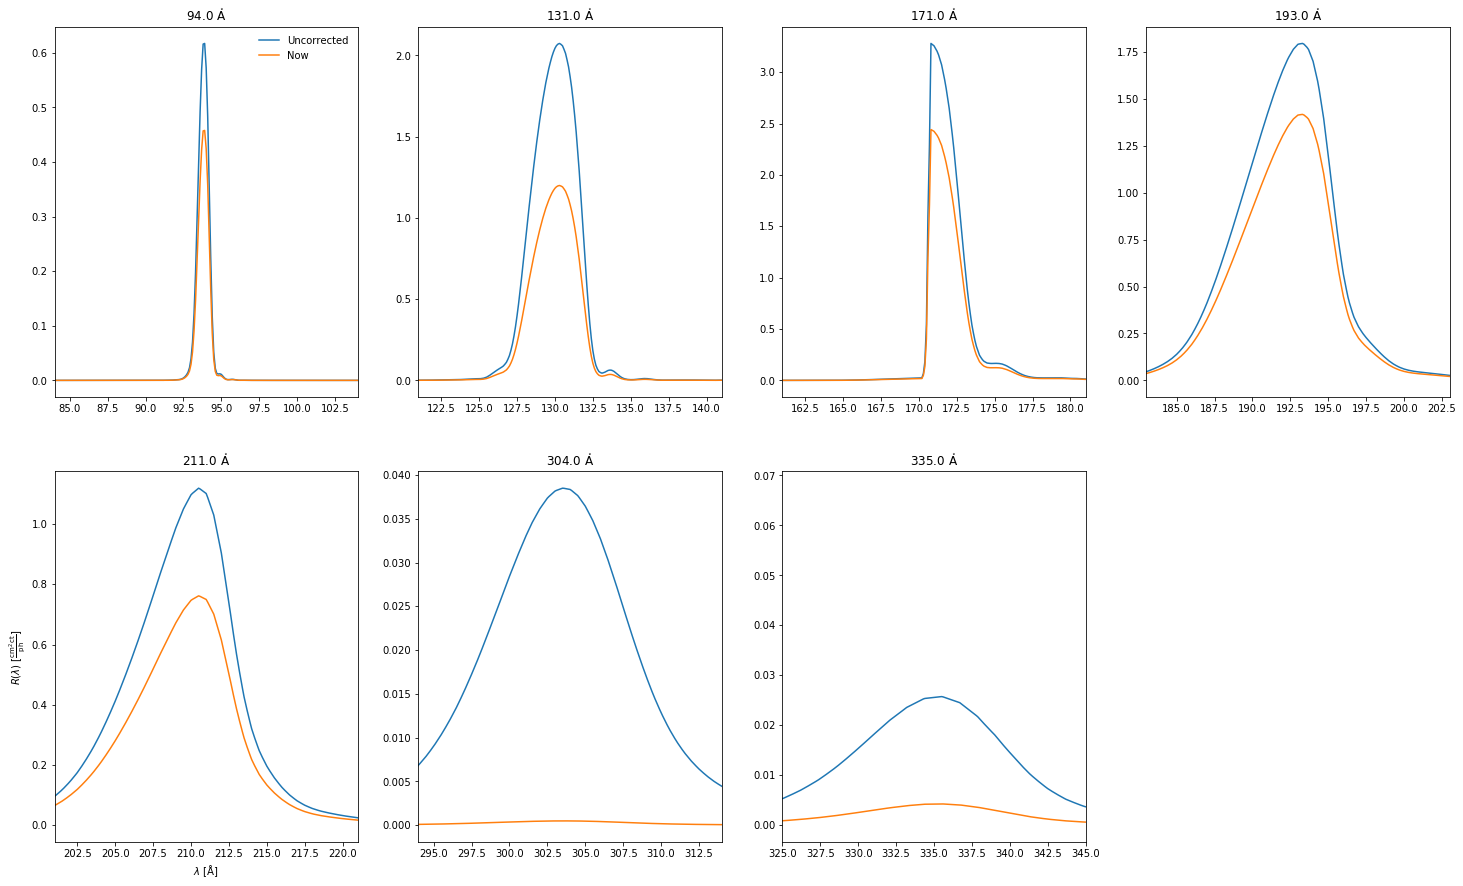

In [23]:
fig = plt.figure(figsize=(25,15))
for i,c in enumerate([94,131,171,193,211,304,335] * u.angstrom):
    ax = fig.add_subplot(2,4,i+1)
    ax.plot(response_all[c]['wavelength'], response_all[c]['response'],
            color='C0', ls='-', label='Uncorrected')
    ax.plot(response_all_now[c]['wavelength'], response_all_now[c]['response'],
            color='C1', ls='-',label='Now')
    ax.set_xlim((c+[-10,10]*u.angstrom).value)
    ax.set_title(f'{c.value} {c.unit.to_string("latex")}')
    if i == 4:
        ax.set_xlabel(r'$\lambda$ [Å]')
        ax.set_ylabel(f'$R(\lambda)$ [{response_all[c]["response"].unit.to_string("latex")}]')
    if i == 0:
        ax.legend(frameon=False)